In [2]:
import pandas as pd
%pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

  Obtaining dependency information for mlxtend from https://files.pythonhosted.org/packages/73/da/d5d77a9a7a135c948dbf8d3b873655b105a152d69e590150c83d23c3d070/mlxtend-0.23.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 325.1 kB/s eta 0:00:05
    --------------------------------------- 0.0/1.4 MB 325.1 kB/s eta 0:00:05
   - -------------------------------------- 0.1/1.4 MB 328.2 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/1.4 MB 435.7 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.4 MB 435.7 kB/s eta 0:00:04
   ---- ----------------------------------- 0.2/1.4 MB 482.7 kB/s eta 0:00:03
   ------ --------------------------------- 0.2/1.4 MB 625.1 kB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.4 MB 625.1 kB/s eta 0:00:02
   ---------- ------------------------

In [8]:
import numpy as np

In [3]:
Train= pd.read_csv('Data/Train.csv')
Test= pd.read_csv('Data/Test.csv')

In [4]:
Train.head()

,RecordID,hospital_id,icu_id,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,apache_3j_bodysystem,apache_2_bodysystem,...,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,d1_glucose_max,d1_potassium_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,immunosuppression,solid_tumor_with_metastasis,hospital_death
0,1,126,1931,Caucasian,M,Floor,transfer,Med-Surg ICU,Metabolic,Metabolic,...,86,93.0,86.0,NaN,NaN,0.01,0.00,0,0,0
1,2,112,1544,African American,M,Accident & Emergency,admit,Med-Surg ICU,Cardiovascular,Cardiovascular,...,95,95.0,95.0,333.0,3.7,NaN,NaN,0,0,0
2,3,153,1517,Caucasian,M,Floor,admit,MICU,Respiratory,Respiratory,...,162,174.0,162.0,160.0,4.2,0.38,0.15,0,0,0
3,4,109,1811,Caucasian,M,Accident & Emergency,admit,Med-Surg ICU,Neurological,Neurologic,...,140,163.0,140.0,258.0,3.8,0.12,0.06,0,0,0
4,5,287,1845,Caucasian,F,Accident & Emergency,admit,CSICU,Cardiovascular,Cardiovascular,...,119,119.0,119.0,110.0,3.9,0.15,0.07,0,0,0


In [5]:
#for all binary columns we will apply knn imputer for missing values
#first we will create a list of all binary columns
binary_cols = ['elective_surgery', 'apache_post_operative', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache','immunosuppression', 'solid_tumor_with_metastasis']
#now we will apply knn imputer on these columns
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
Train[binary_cols] = imputer.fit_transform(Train[binary_cols])
Test[binary_cols] = imputer.fit_transform(Test[binary_cols])


In [9]:
numeric_cols = [col for col in Train.select_dtypes(include=[np.number]).columns if col not in binary_cols]
numeric_colsTest = [col for col in Test.select_dtypes(include=[np.number]).columns if col not in binary_cols]
#now run mean imputer on numeric_data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
Train[numeric_cols] = imputer.fit_transform(Train[numeric_cols])
#do same for test
Test[numeric_colsTest] = imputer.fit_transform(Test[numeric_colsTest])

In [10]:
categorical_data = Train.select_dtypes(exclude=[np.number])
categorical_dataTest = Test.select_dtypes(exclude=[np.number])

In [11]:
#fill in the cateogrical data using mode iputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
Train[categorical_data.columns] = imputer.fit_transform(Train[categorical_data.columns])
#do same for test
Test[categorical_dataTest.columns] = imputer.fit_transform(Test[categorical_dataTest.columns])

In [13]:
Test.isnull().sum().sum()  

0

In [22]:
NONCategoric_colsTrain= [col for col in Train.select_dtypes(include=[np.number]).columns]
# make a dataframe for numeric values
NONCategoric_dataTrain = Train[NONCategoric_colsTrain]


In [23]:
NONCategoric_colsTest = [col for col in Test.select_dtypes(include=[np.number]).columns]
# make a dataframe for numeric values
NONCategoric_dataTest = Test[NONCategoric_colsTest]


In [52]:
NONCategoric_dataTest.shape

(30000, 50)

In [116]:
X = NONCategoric_dataTrain.loc[:, NONCategoric_dataTrain.columns != 'hospital_death']
y = NONCategoric_dataTrain[['hospital_death']]

In [117]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=(train_test_split(X, y, test_size=0.3, random_state=2))

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
fwd_feature_selector = SFS(RandomForestClassifier(n_jobs = -1), k_features=10, forward=True,
                                                  floating=False, verbose=2, scoring='roc_auc', cv=5).fit(X_train, y_train)
#cv is croos validation 5 times
#The cv=5 parameter means that this process is done using 5-fold cross-validation on your training data (X_train and y_train). 
# In each fold of the cross-validation, 4/5 of the data is used for training and 1/5 is used for validation.
# The ROC AUC score is averaged over the 5 folds to give a more robust estimate of the model’s performance.
                           

C:\Users\hamza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hamza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hamza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

In [118]:
fwd_feature_selector.k_feature_names_     # to get the final set of features


('elective_surgery',
 'apache_post_operative',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'h1_sysbp_noninvasive_min',
 'apache_4a_hospital_death_prob',
 'immunosuppression',
 'solid_tumor_with_metastasis')

In [119]:
from sklearn.metrics import roc_auc_score

# Transform X_test to contain only the selected features
X_test_transformed = fwd_feature_selector.transform(X_test)

# Fit the model on the transformed X_train
# model = DecisionTreeClassifier(max_depth=2, min_samples_split= 10)
model = DecisionTreeClassifier()
model.fit(fwd_feature_selector.transform(X_train), y_train)

# Predict and evaluate on the transformed X_test
y_pred = model.predict(X_test_transformed)
print(roc_auc_score(y_test, y_pred))


0.6171569609012475


In [123]:
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

# Transform X_test to contain only the selected features
X_test_transformed = fwd_feature_selector.transform(X_test)

# Fit the model on the transformed X_train
model = KNeighborsClassifier(n_neighbors=1)
model.fit(fwd_feature_selector.transform(X_train), y_train)

# Predict and evaluate on the transformed X_test
y_pred = model.predict(X_test_transformed)
print(roc_auc_score(y_test, y_pred))


C:\Users\hamza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.6014489042615645


In [130]:
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB

# Transform X_test to contain only the selected features
X_test_transformed = fwd_feature_selector.transform(X_test)

# Fit the model on the transformed X_train
model = GaussianNB()
model.fit(fwd_feature_selector.transform(X_train), y_train)

# Predict and evaluate on the transformed X_test
y_pred = model.predict(X_test_transformed)
print(roc_auc_score(y_test, y_pred))


0.6763631285898478


C:\Users\hamza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [131]:
XTEST = NONCategoric_dataTest.loc[:, NONCategoric_dataTest.columns != 'hospital_death']


In [132]:
from sklearn.metrics import roc_auc_score

# Transform X_test to contain only the selected features
X_test_transformed = fwd_feature_selector.transform(XTEST)




In [133]:
# Predict and evaluate on the transformed X_test
hospital_death = model.predict(X_test_transformed)


In [144]:
# Create a DataFrame for the predictions
predictions_df = pd.DataFrame(hospital_death, columns=['hospital_death'])

# Add the record ID from the test data to the predictions DataFrame
predictions_df.insert(0, 'RecordID', NONCategoric_dataTest['RecordID'])

# Save the predictions to a CSV file
predictions_df.to_csv('predictionsFWDSLEECTION.csv', index=False)

In [135]:
predictions_df.shape

(30000, 2)

In [ ]:
fwd_feature_selector = SFS(RandomForestClassifier(n_jobs = -1), k_features=(1,13), forward=True,
                                                  floating=False, verbose=2, scoring='roc_auc', cv=5).fit(X_train, y_train)
#cv is croos validation 5 times

                           

In [67]:
#ONLY CATEOGRICAL DATA
df_onehotTrainCAT = pd.get_dummies(categorical_data)


In [68]:
#ONLY CATEOGRICAL DATA
df_onehotTestcat = pd.get_dummies(categorical_dataTest)


In [62]:
df_onehotTrain.isnull().sum().sum()

0

In [69]:
from sklearn.feature_selection import chi2
X=df_onehotTrainCAT
y=Train['hospital_death']

In [70]:
X.head()

,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_F,gender_M,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,...,apache_2_bodysystem_Cardiovascular,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
0,0,0,1,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [71]:
chi_scores = chi2(X,y)

<AxesSubplot: >

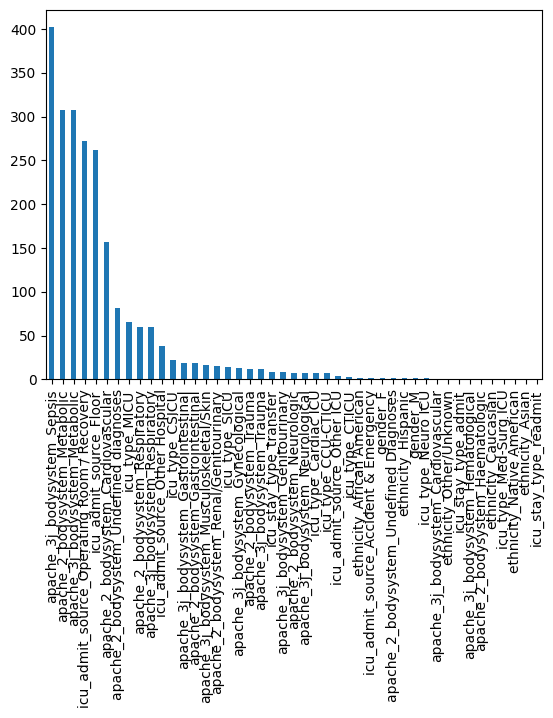

In [73]:
chi_values=pd.Series(chi_scores[0],index=X.columns)     
chi_values.sort_values(ascending=False,inplace=True)
chi_values.plot.bar()

In [98]:
#i only want top 10 features
chi_values=chi_values.head(15)
chi_values

apache_3j_bodysystem_Sepsis                   401.715974
apache_2_bodysystem_Metabolic                 307.276777
apache_3j_bodysystem_Metabolic                307.276777
icu_admit_source_Operating Room / Recovery    272.418762
icu_admit_source_Floor                        262.260589
apache_2_bodysystem_Cardiovascular            156.744981
apache_2_bodysystem_Undefined diagnoses        81.109819
icu_type_MICU                                  65.257772
apache_2_bodysystem_Respiratory                59.638554
apache_3j_bodysystem_Respiratory               59.638554
dtype: float64

In [136]:
#drop all but chi values from df_onehotTrainCAT 
df_onehotTrainCAT = df_onehotTrainCAT[chi_values.index]

In [137]:
#do same for test
df_onehotTestcat = df_onehotTestcat[chi_values.index]

In [138]:
new_train = Train.loc[:, fwd_feature_selector.k_feature_names_]
new_test = Test.loc[:, fwd_feature_selector.k_feature_names_]


In [139]:
#now combine new_train with df_onehotTrainCAT
new_train = pd.concat([new_train, df_onehotTrainCAT], axis=1)
#do same for test
new_test = pd.concat([new_test, df_onehotTestcat], axis=1)

In [140]:
X = new_train
y = Train['hospital_death']

In [141]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=(train_test_split(X, y, test_size=0.3, random_state=2))

In [111]:
from sklearn.metrics import roc_auc_score


# Fit the model on the transformed X_train
# model = DecisionTreeClassifier(max_depth=2, min_samples_split= 10)
model = DecisionTreeClassifier(max_depth=50000, min_samples_split= 2)
model.fit(X_train, y_train)

# Predict and evaluate on the transformed X_test
y_pred = model.predict(X_test)
print(roc_auc_score(y_test, y_pred))


0.6230505121787882


In [142]:
from sklearn.naive_bayes import GaussianNB

# Fit the model on the transformed X_train
model = GaussianNB()
model.fit(X_train, y_train)

# Predict and evaluate on the transformed X_test
y_pred = model.predict(X_test)
print(roc_auc_score(y_test, y_pred))


0.7230377433440315


In [143]:
hospital_death = model.predict(new_test)
